# Pneumonia detection from X-ray images

In [1]:
import os
import random
import numpy as np
from tqdm import tqdm

# Image manipulation
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# DATA

In [2]:
# Final image resolution
res = 64

In [3]:
# Crop images to squares
def to_square(img):
    (h, w) = img.shape
    diff_half = np.abs(h-w) // 2
    
    if w > h:
        return(img[0:h, 0+diff_half:w-diff_half])
    elif w < h:
        return(img[0+diff_half:w-diff_half, 0:w])
    else: 
        return img

In [4]:
def load_data(dataset='train'):
    
    # Path where files are stored
    files_path = '../input/chest_xray/chest_xray/'+dataset
    
    #--- STEP 1: Create list containing names of image files ---#
    names_list = []
    for cat in ['/NORMAL', '/PNEUMONIA']:
        for img_name in os.listdir(files_path+cat):
            # Exclude non-image files
            if img_name[0] in ['I', 'N', 'p']:
                names_list.append(img_name)
    # Shuffle to feed into network
    random.Random(232).shuffle(names_list)
    
    #--- STEP 2: Create list of labels ---#
    labels = []
    for img_name in names_list:
        # 0 for normal, 1 for pneumonia
        if img_name[0] in ['I', 'N']:
            labels.append(0)
        elif img_name[0] == 'p':
            labels.append(1)
            
    #--- STEP 3: Load images and process them ---#
    img_list = []
    for img_name in tqdm(names_list):
        try:
            # Load images 
            if img_name[0] in ['I', 'N']:
                img = plt.imread(files_path+'/NORMAL/'+img_name)
            elif img_name[0] == 'p':
                img = plt.imread(files_path+'/PNEUMONIA/'+img_name)
                
            # Process images (normalize, square, reduce resolution)
            if len(img.shape) == 3:
                img = img[:,:,0]
            img = img / 255
            img = to_square(img)
            img = cv2.resize(img, dsize=(res, res), interpolation=cv2.INTER_AREA)
            img = img.reshape(res, res, 1)
            img = np.dstack([img, img, img])
            img_list.append(img)
        except OSError:
            pass
    
    return np.array(img_list), np.array(labels)

In [5]:
# Load data into each dataset pair
x_train, y_train = load_data(dataset='train')
x_val, y_val = load_data(dataset='val')
x_test, y_test = load_data(dataset='test')

100%|██████████| 624/624 [00:09<00:00, 65.24it/s]


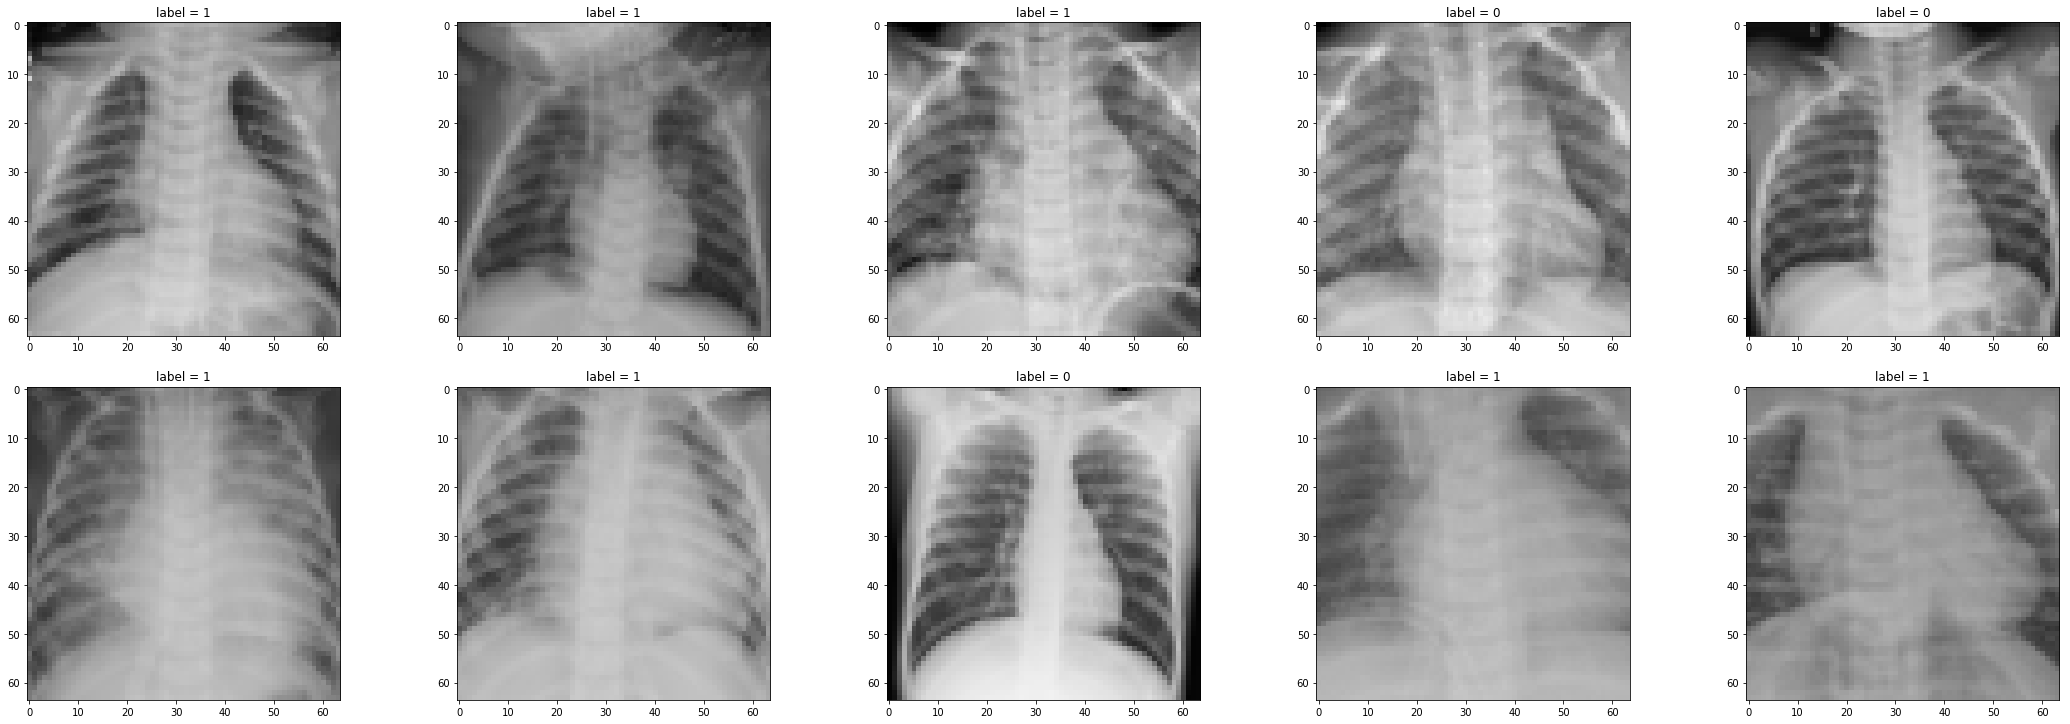

In [6]:
# Visualizing xrays
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
ax = ax.ravel()
plt.tight_layout(h_pad=3)

for i in range(ax.shape[0]):
    ax[i].imshow(x_test[i], cmap='gray')
    ax[i].set_title('label = {}'.format(y_test[i]))

# CUSTOM MODEL

In [7]:
from keras.models import Model, Sequential 
from keras.layers import Input, Dense, Flatten, Dropout, LeakyReLU, BatchNormalization, Conv2D, MaxPool2D

Using TensorFlow backend.


In [8]:
# Model parameters
ks33 = (3, 3)
ks22 = (2, 2)

In [9]:
# Design model with Keras Funcitonal API 
inputs = Input(shape=(res, res, 3))

# Convolutional layer 1
conv1 = Conv2D(filters=16, kernel_size=ks33, activation='relu', padding='same')(inputs)
conv1 = Conv2D(filters=16, kernel_size=ks33, activation='relu', padding='same')(conv1)
conv1 = MaxPool2D(pool_size=(2, 2))(conv1)

# Convolutional layer 2
conv2 = Conv2D(filters=32, kernel_size=ks33, activation='relu', padding='same')(conv1)
conv2 = Conv2D(filters=32, kernel_size=ks33, activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = MaxPool2D(pool_size=(2, 2))(conv2)

# Convolutional layer 3
conv3 = Conv2D(filters=64, kernel_size=ks33, activation='relu', padding='same')(conv2)
conv3 = Conv2D(filters=64, kernel_size=ks33, activation='relu', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = MaxPool2D(pool_size=(2, 2))(conv3)

# Fully-Connected layer
fc = Flatten()(conv3)
fc = Dense(units=256, activation='relu')(fc)
fc = Dropout(rate=0.5)(fc)
fc = Dense(units=64, activation='relu')(fc)
fc = Dropout(rate=0.2)(fc)

# Output
output = Dense(units=1, activation='sigmoid')(fc)

# Create model and compile
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Tuning:

In [10]:
# Model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
__________

In [11]:
# Callbacks and image preprocessing
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
img_aug = ImageDataGenerator(rotation_range=20, vertical_flip=True, horizontal_flip=True)
img_aug.fit(x_train)

In [12]:
# Hyperparameters for fitting
batch_size = 74
epochs = 7
steps = x_train.shape[0] // batch_size

# Fitting model to data (val set too small, use test for validation)
model.fit_generator(img_aug.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=steps, epochs=epochs, 
                    validation_data=(x_test, y_test), callbacks=[reduce_lr], 
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/7
70/70 [==============================] - 8s 116ms/step - loss: 0.3476 - acc: 0.8741 - val_loss: 0.5819 - val_acc: 0.7548
Epoch 2/7
70/70 [==============================] - 5s 64ms/step - loss: 0.2049 - acc: 0.9173 - val_loss: 0.6425 - val_acc: 0.7388
Epoch 3/7
70/70 [==============================] - 5s 66ms/step - loss: 0.1645 - acc: 0.9372 - val_loss: 2.2506 - val_acc: 0.3958
Epoch 4/7
70/70 [==============================] - 5s 65ms/step - loss: 0.1814 - acc: 0.9330 - val_loss: 4.8040 - val_acc: 0.6250
Epoch 5/7
70/70 [==============================] - 5s 65ms/step - loss: 0.1497 - acc: 0.9448 - val_loss: 0.7180 - val_acc: 0.6939
Epoch 6/7
70/70 [==============================] - 5s 65ms/step - loss: 0.1433 - acc: 0.9428 - val_loss: 0.8937 - val_acc: 0.7356

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/7
70/70 [==============================] - 5s 65ms/step - loss: 0.1133 - acc: 0.95

In [13]:
# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# Getting predictions
predictions = model.predict(x=x_test)

acc = accuracy_score(y_test, np.round(predictions))*100
tn, fp, fn, tp = confusion_matrix(y_test, np.round(predictions)).ravel()

print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(tp/(tp+fp)*100))
print('Recall: {}%'.format(tp/(tp+fn)*100))


Accuracy: 81.73076923076923%
Precision: 79.87012987012987%
Recall: 94.61538461538461%
